In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.sparse import csr_matrix, diags, spdiags, kronsum
from scipy.sparse.linalg import spsolve, eigs, eigsh
from numba import jit, njit

In [2]:
nr = 128
nz = 128
hbar = 1.05457e-34
m_e = 9.109e-31#0.067*9.109e-31
R, Z = 40e-9, 40e-9
angle = 20*np.pi/180

In [3]:
def u(x):
    res = np.ones_like(x)
    res[x>=0] = 1.0
    res[x<0] = 0
    return res

# def V(rc, r, z):
#     V = -0.697*1.6022e-19/Cr
#     d = 0.2
#     h = rc*np.tan(np.pi/15)
#     potential = V*(u(z-d)*u(d+h-z)*u(h+d-z-r*np.tan(np.pi/15)) + u(z)*u(d-z))
#     return potential

def V(Rt, r, z, V0 = -0.697*1.6022e-19):
    d = 0.5
    d0 = 0.5
    rc = Rt
    h = rc*np.tan(angle)
    potential = V0*(u(z-d)*u(d+h-z)*u(h+d-z-r*np.tan(angle)) + u(z-d0)*u(d-z))*u(Rt-r)
    return potential

def V_h_hole(Rt, r, z, V0 = 0.288*1.6022e-19):
    d = 0.5
    d0 = 0.5
    rc = Rt
    h = rc*np.tan(angle)
    potential = V0*(u(z-d)*u(d+h-z)*u(h+d-z-r*np.tan(angle)) + u(z-d0)*u(d-z))*u(Rt-r)
    return potential

def V_l_hole(Rt, r, z, V0 = 0.117*1.6022e-19):
    d = 0.5
    d0 = 0.5
    rc = Rt
    h = rc*np.tan(angle)
    potential = V0*(u(z-d)*u(d+h-z)*u(h+d-z-r*np.tan(angle)) + u(z-d0)*u(d-z))*u(Rt-r)
    return potential

# def V(Rt, r, z):
#     V = -0.697*1.6022e-19/Cr
#     d = 0.5
#     d0 = 0.48
#     rc = Rt #- (d-d0)/np.tan(np.pi/15)
#     h = rc*np.tan(np.pi/15)
#     potential = V*(u(z-d)*u(d+h-z)*u(h+d-z-r*np.tan(np.pi/15)) + u(z-d0)*u(d-z))*u(r)
#     return potential

# def V(V, r, z):
#     d = 0.5
#     d0 = 0.5
#     Rt = 0.5
#     rc = Rt - (d-d0)/np.tan(np.pi/15)
#     h = rc*np.tan(np.pi/15)
#     potential = -V*(u(z-d)*u(d+h-z)*u(h+d-z-r*np.tan(np.pi/15)) + u(z-d0)*u(d-z))*u(r)
#     return potential

In [4]:
def Hamiltonian(V, nphi, rc, nr=128, nz=128, mz=m_e, mr = m_e, Rlim = R, Zlim = Z):
    
    N = nr*nz
    
    dr = 1/(nr - 1)
    dz = 1/(nz - 1)
    Cr = hbar**2/(2*mr*Rlim**2)
    Cz = hbar**2/(2*mz*Zlim**2)
    r = np.arange(0, 1 + dr, dr)
    z = np.arange(0, 1 + dz, dz)
    r[0] = dr/1000

    diags_d_r  = np.array([-np.ones(nr)*np.roll(1/r, -1), np.ones(nr)*np.roll(1/r, 1)])
    diags_d_r[1, 1] = 0
    diags_dd_r = np.array([np.ones(nr), -2*np.ones(nr), np.ones(nr)])
    diags_dd_r[1, 0] = -1
    diags_dd_z = np.array([np.ones(nz), -2*np.ones(nz), np.ones(nz)])

    dd_r = spdiags(diags_dd_r, np.array([-1, 0, 1]), nr, nr)/dr**2
    dd_z = Cz/Cr*spdiags(diags_dd_z, np.array([-1, 0, 1]), nz, nz)/dz**2
    d_r = spdiags(diags_d_r, np.array([-1, 1]), nr, nr)/dr/2
    n_rr = diags(nphi/r**2, 0)
    r[0] = 0
    T = -kronsum((dd_r + d_r - n_rr), dd_z)
    rmesh, zmesh = np.meshgrid(r, z)
    Hamiltonian = T + diags((V(rc, rmesh, zmesh)/Cr).reshape(N), 0)
    return Hamiltonian

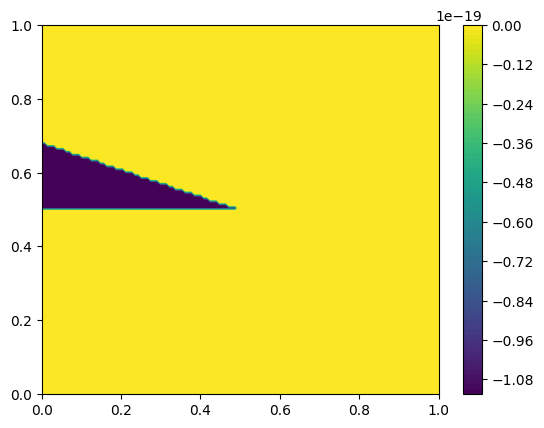

In [5]:
dr = 1/(nr - 1)
dz = 1/(nz - 1)
r = np.arange(0, 1 + dr, dr)
z = np.arange(0, 1 + dz, dz)
rmesh, zmesh = np.meshgrid(r, z)
plt.contourf(r, z, V(0.50, rmesh, zmesh), levels = 100)
plt.colorbar()
plt.show()

def E(V, rc, nphi, m_z=m_e, m_r=m_e):
    h = Hamiltonian(V, nphi, rc, mz=m_z, mr=m_r)
    return sorted(eigs(h, k = 8, which="SR", tol=1e-10)[0])[:3]

In [6]:
mer, mez = 0.067*m_e, 0.067*m_e
mHhr, mHhz = -0.11*m_e, -0.34*m_e
mLhr, mLhz = -0.21*m_e, -0.09*m_e

In [7]:
Rts = np.linspace(0.125, 0.375, 21)
Es0 = []
Es1 = []
for Rt in Rts:
    Es0.append(E(V, Rt, 0, m_r=mer, m_z=mez)[0])
    Es1.append(E(V, Rt, 1, m_r=mer, m_z=mez)[0])

In [8]:
Cr = hbar**2/(2*0.067*m_e*R**2)
CLhr = hbar**2/(2*mHhr*R**2)
CHhr = hbar**2/(2*mHhr*R**2)
eV = 1.6022e-19

In [9]:
ground_state_energies = np.real(np.array(Es0))*Cr/eV
first_excited_energies = np.real(np.array(Es1))*Cr/eV

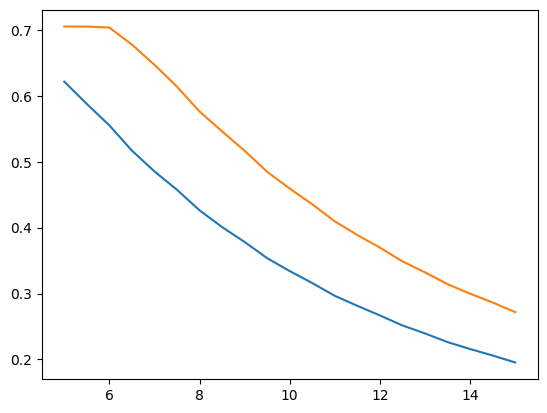

In [10]:
plt.plot(40*Rts, ground_state_energies + 0.697)
plt.plot(40*Rts, first_excited_energies + 0.697)
plt.show()

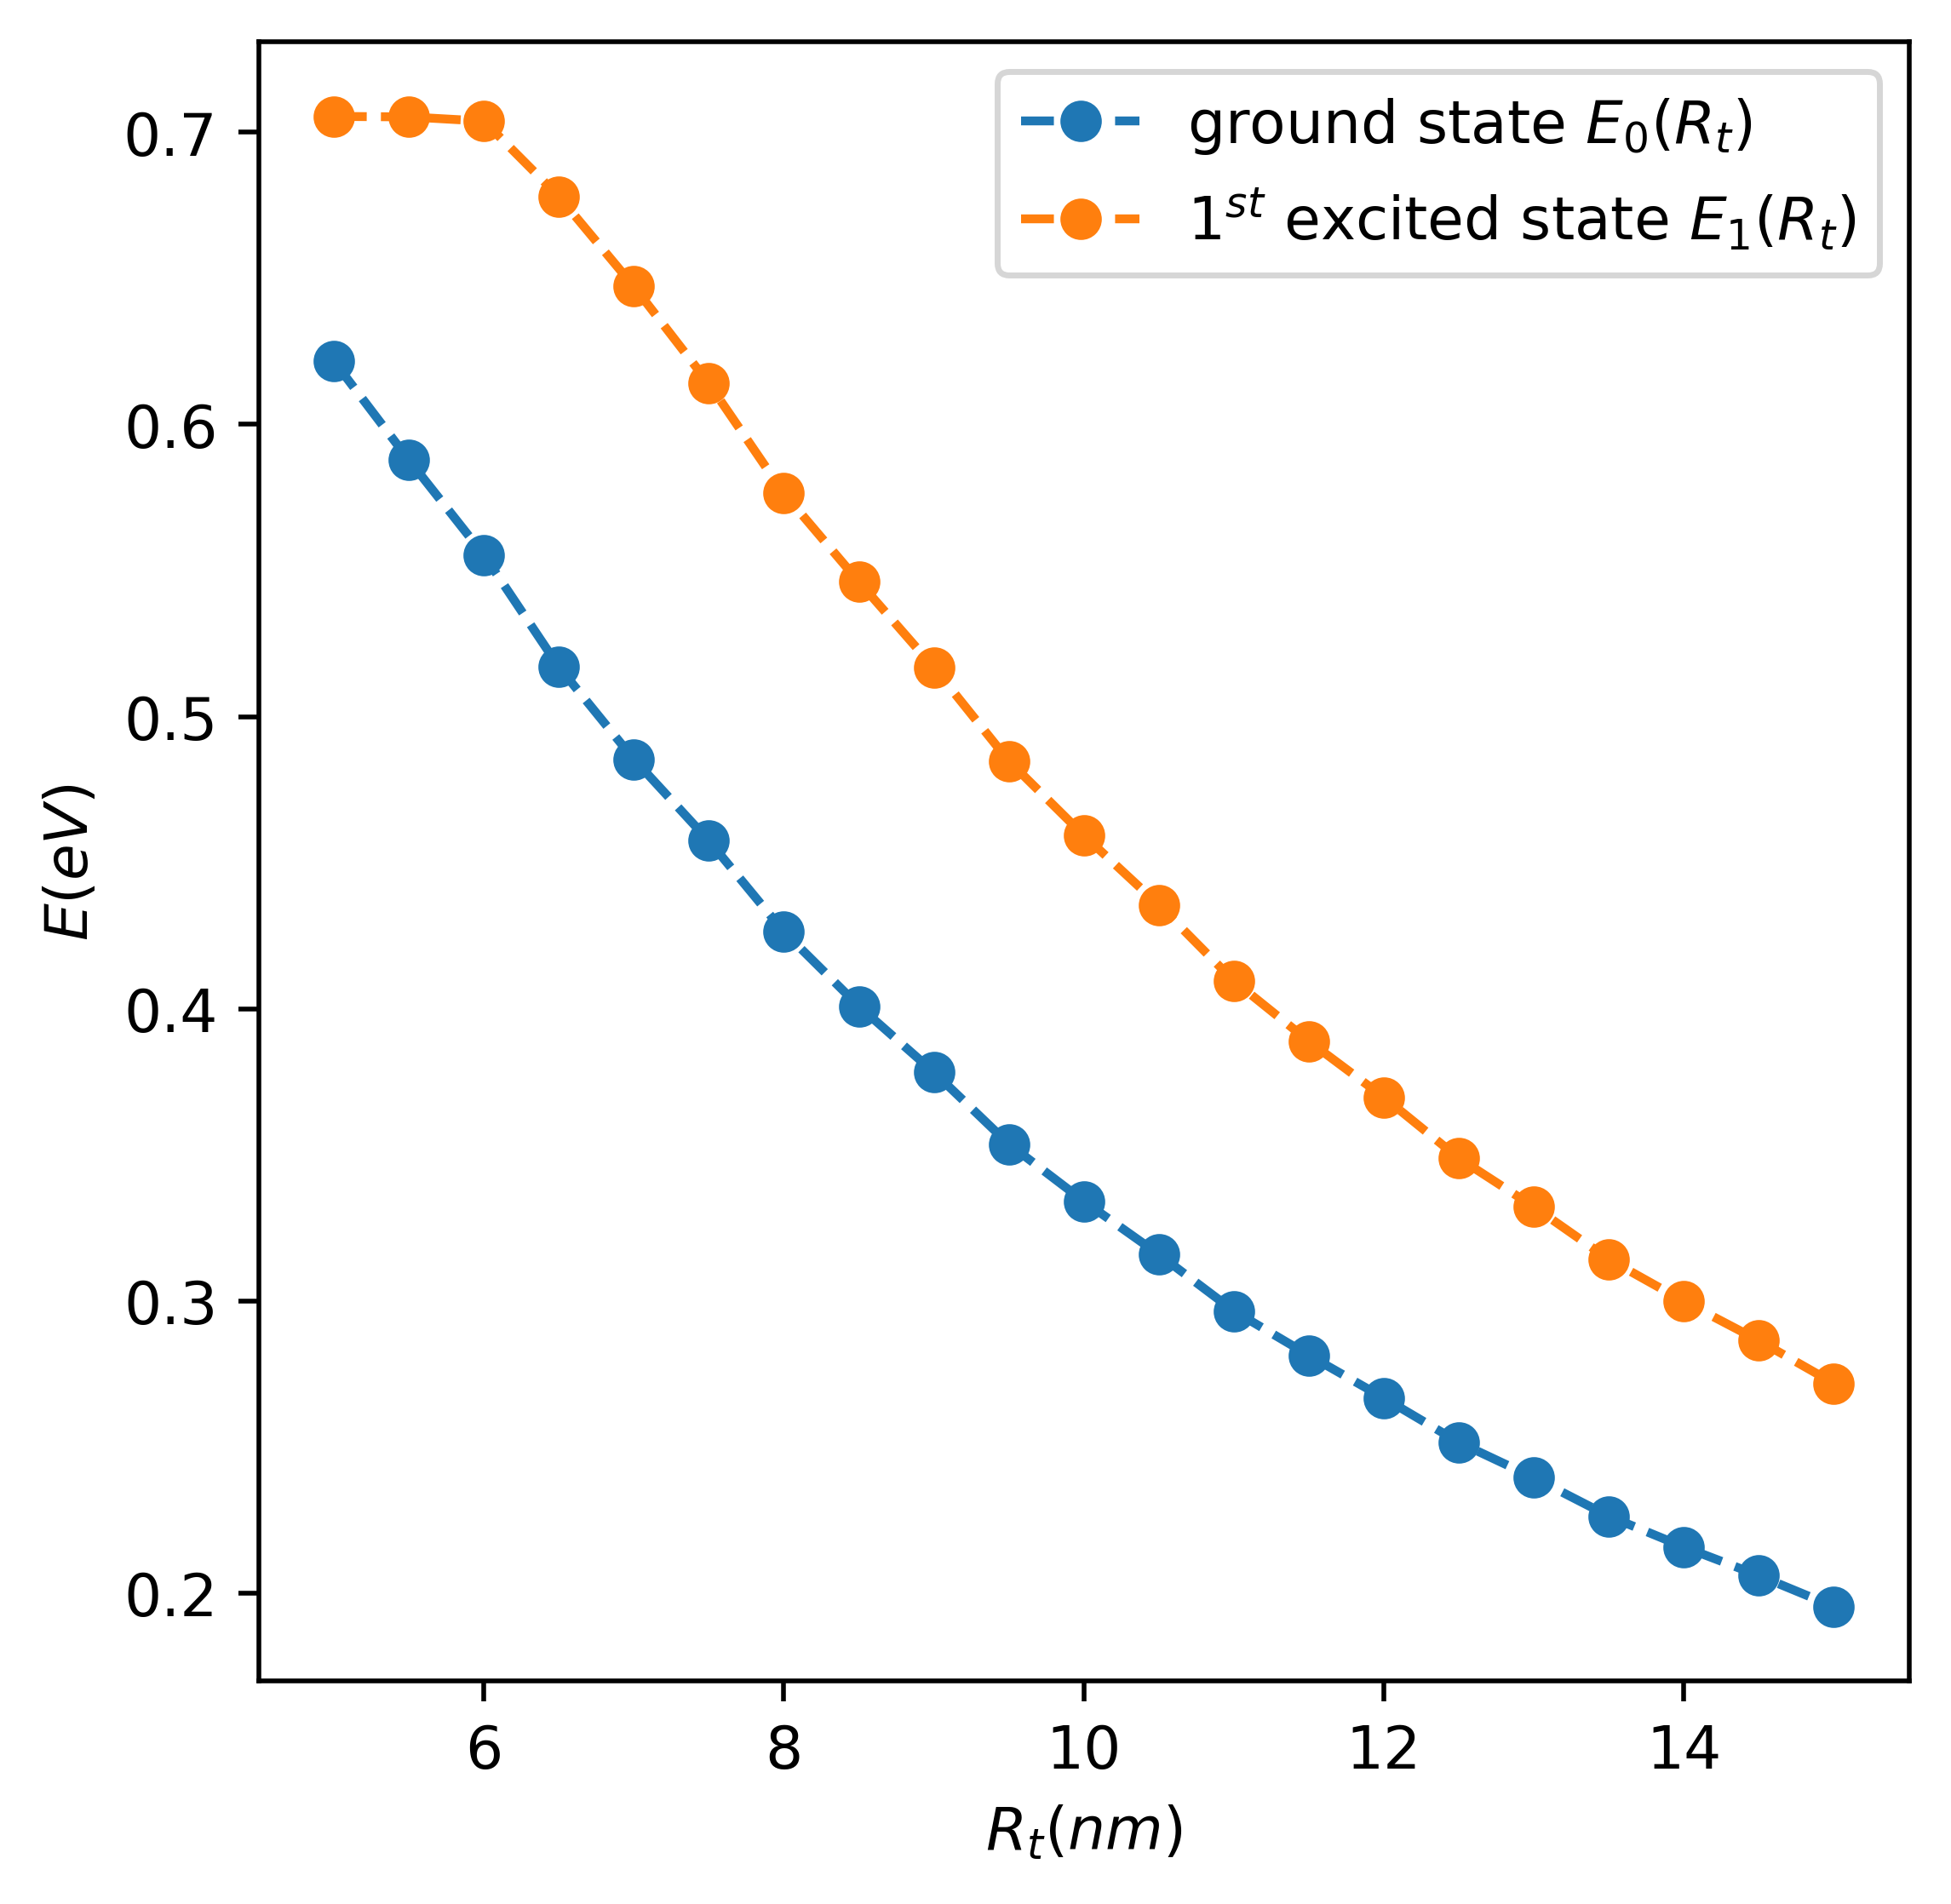

In [11]:
plt.figure(dpi = 500, figsize=(5, 5))
plt.xlabel(r"$R_t(nm)$")
plt.ylabel(r"$E(eV)$")
plt.plot(40*Rts, ground_state_energies + 0.697,'--o', label = r"ground state $E_0(R_t)$")
plt.plot(40*Rts, first_excited_energies + 0.697,'--o', label = r"$1^{st}$ excited state $E_1(R_t)$")
plt.legend()
plt.show()

In [12]:
from scipy.optimize import curve_fit

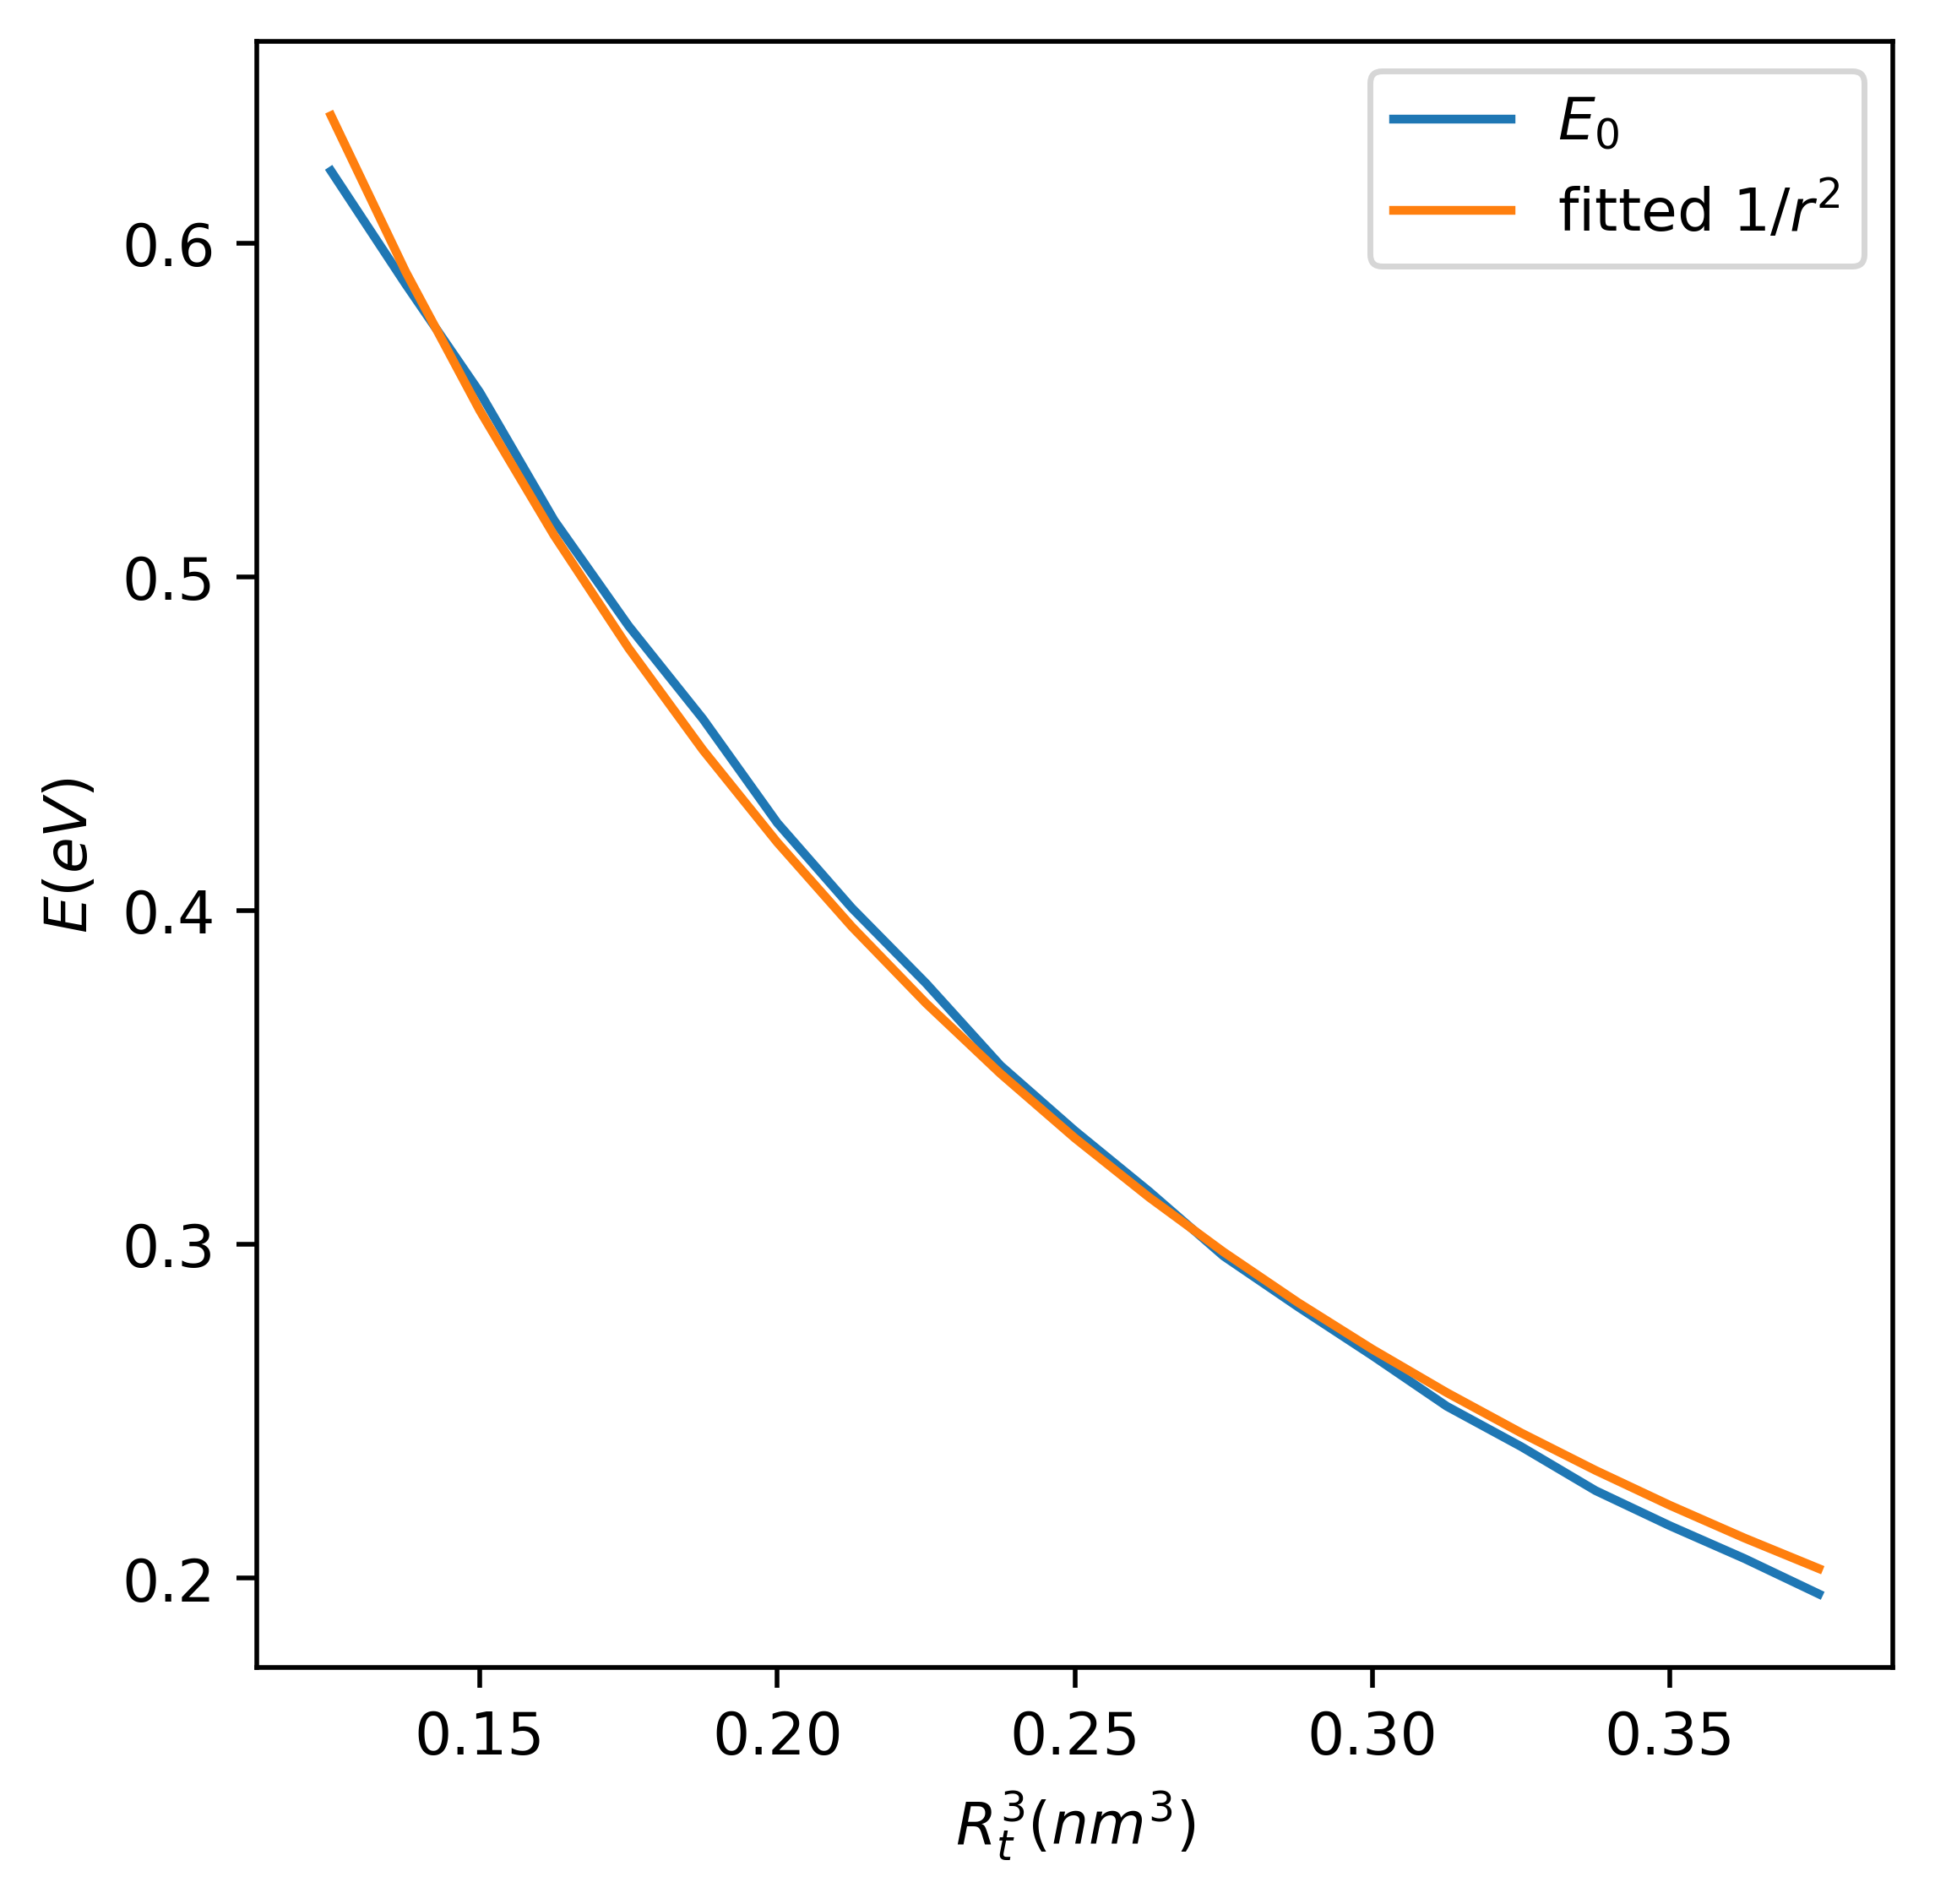

In [13]:
plt.figure(dpi = 500, figsize=(5, 5))
plt.xlabel(r"$R_t^3(nm^3)$")
plt.ylabel(r"$E(eV)$")

plt.plot(Rts, ground_state_energies + 0.697, label=r"$E_0$")

inv_quad = lambda x, a, b: a/(x+b)**2

optimal_par = curve_fit(inv_quad, Rts, ground_state_energies + 0.697)

plt.plot(Rts, inv_quad(Rts, optimal_par[0][0], optimal_par[0][1]), label=r"fitted $1/r^2$")
plt.legend()
plt.show()

In [14]:
np.sqrt(np.diag(optimal_par[1]))/optimal_par[0]

array([0.02430859, 0.02354319])

In [15]:
Rts = np.linspace(0.125, 0.375, 21)
ELh0 = []
ELh1 = []
for Rt in Rts:
    ELh0.append(E(V_l_hole, Rt, 0, m_r=mLhr, m_z=mLhz)[0])
    ELh1.append(E(V_l_hole, Rt, 1, m_r=mLhr, m_z=mLhz)[0])

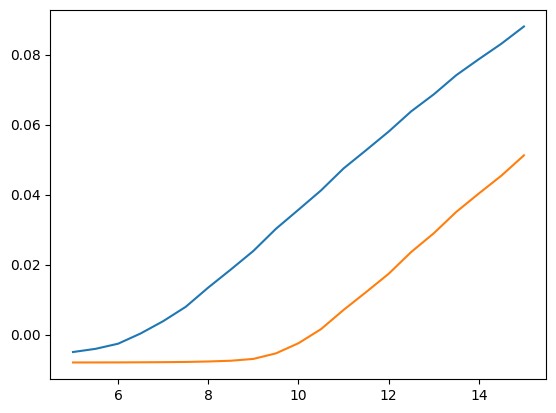

In [16]:
plt.plot(40*Rts, np.real(ELh0)*CLhr/eV)
plt.plot(40*Rts, np.real(ELh1)*CLhr/eV)
plt.show()

In [17]:
Rts = np.linspace(0.125, 0.375, 21)
EHh0 = []
EHh1 = []
for Rt in Rts:
    EHh0.append(E(V_h_hole, Rt, 0, m_r=mLhr, m_z=mLhz)[0])
    EHh1.append(E(V_h_hole, Rt, 1, m_r=mLhr, m_z=mLhz)[0])

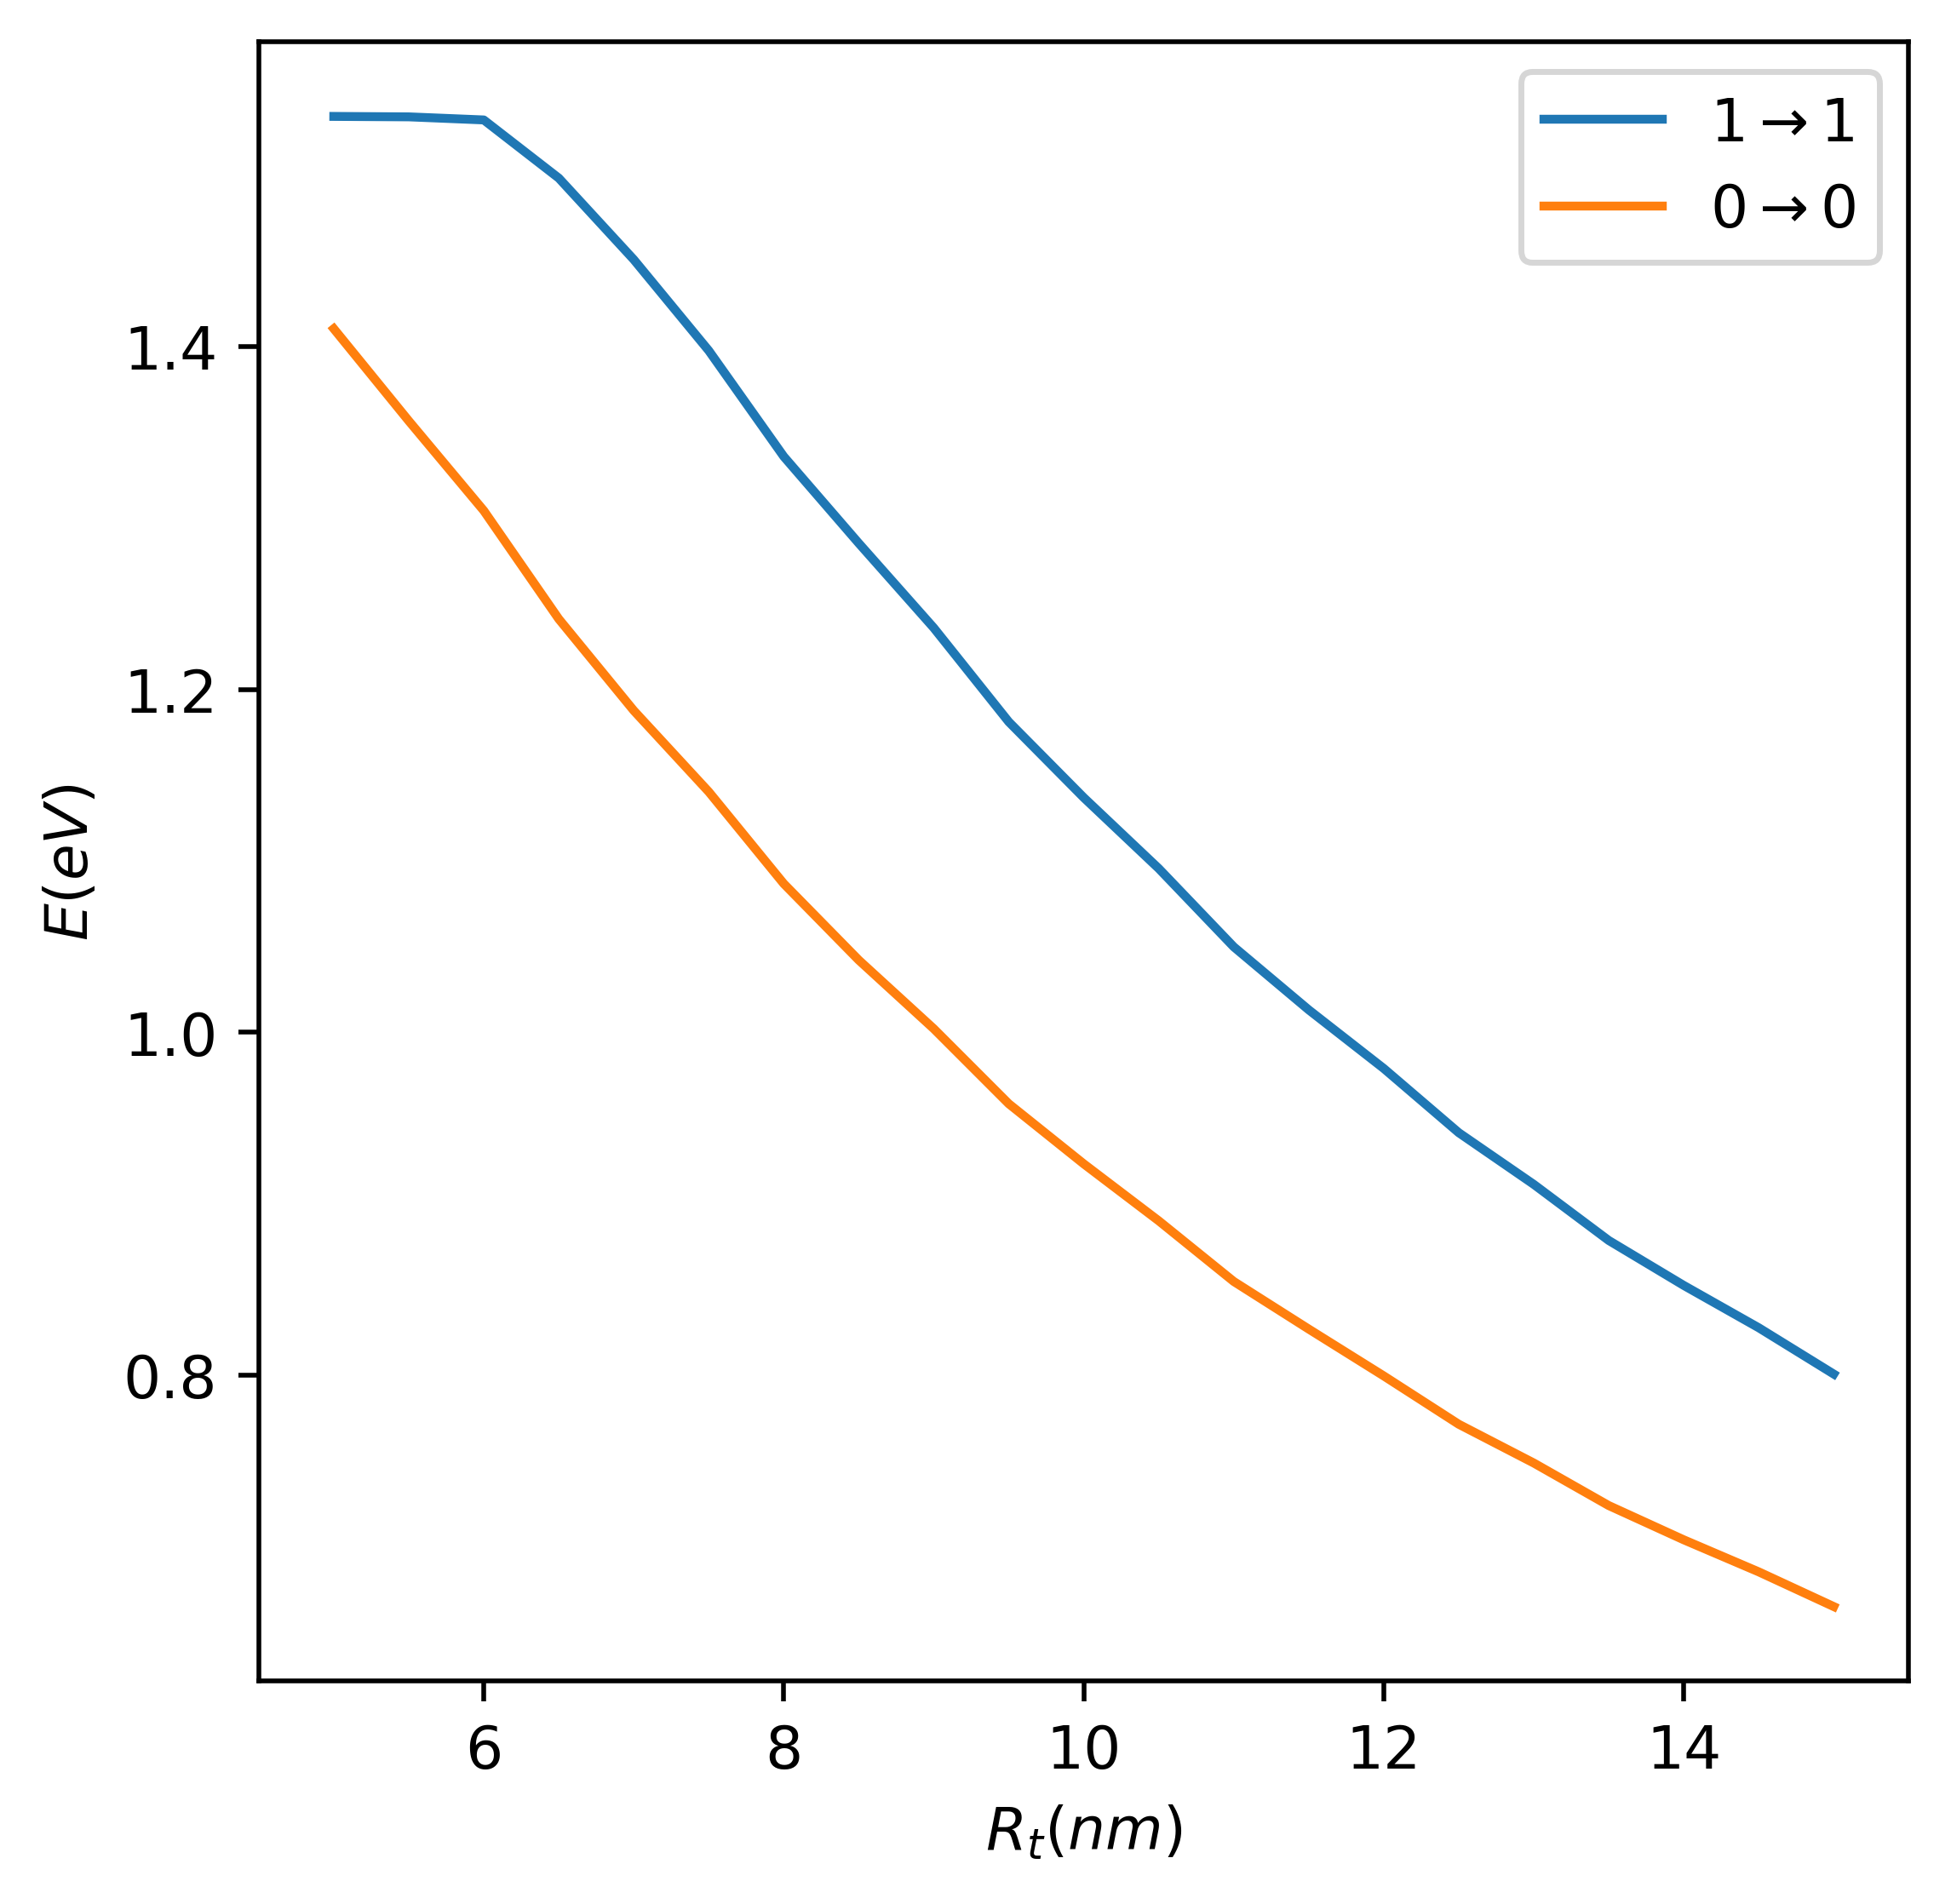

In [18]:
plt.figure(dpi = 500, figsize=(5, 5))
plt.xlabel(r"$R_t(nm)$")
plt.ylabel(r"$E(eV)$")
# plt.plot(40*Rts, 0.288 + 0.697 + 0.533 + first_excited_energies-(np.real(EHh0)*CHhr/eV), label=r"$1 \to 0$")
plt.plot(40*Rts, 0.288 + 0.697 + 0.533 + first_excited_energies-(np.real(EHh1)*CHhr/eV), label=r"$1 \to 1$")
plt.plot(40*Rts, 0.288 + 0.697 + 0.533 + ground_state_energies-(np.real(EHh0)*CHhr/eV), label=r"$0 \to 0$")
# plt.plot(40*Rts, 0.288 + 0.697 + 0.533 + ground_state_energies-(np.real(EHh1)*CHhr/eV), label=r"$0 \to 1$")
# plt.plot(40*Rts, 0.117 + 0.697 + 0.703 + ground_state_energies-(np.real(ELh0)*CLhr/eV), label=r"$\ell: 0 \to 0$")
plt.legend()
plt.show()

In [19]:
ind = -4
print(40*Rts[ind], (0.288 + 0.697 + 0.533 + ground_state_energies-(np.real(EHh0)*CHhr/eV))[ind])

13.5 0.7239209866873876
